<a href="https://colab.research.google.com/github/Preetibanga18/githubactions-codespace/blob/main/preeti_human_pose_revised_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import mediapipe as mp
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,explained_variance_score,confusion_matrix
from sklearn.model_selection import train_test_split

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

ModuleNotFoundError: No module named 'mediapipe'

In [ ]:
def extract_keypoints(image):
    """Extract keypoints using MediaPipe."""
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    keypoints = np.zeros((33, 4))  # MediaPipe Pose has 33 keypoints
    if results.pose_landmarks:
        for i, landmark in enumerate(results.pose_landmarks.landmark):
            keypoints[i] = [landmark.x, landmark.y, landmark.z, landmark.visibility]
    return keypoints

def calculate_features(keypoints):
    """Calculate features such as distances and angles from keypoints."""
    features = {}
    if len(keypoints) == 0:
        return np.zeros(10)  # Return empty features if no keypoints detected
    # Extract coordinates for shoulders, hips, etc.
    left_shoulder, right_shoulder = keypoints[11][:2], keypoints[12][:2]
    left_hip, right_hip = keypoints[23][:2], keypoints[24][:2]

    # Calculate widths and ratios
    shoulder_width = np.linalg.norm(right_shoulder - left_shoulder)
    hip_width = np.linalg.norm(right_hip - left_hip)
    waist_width = 0.8 * hip_width
    bust_width = 0.95 * hip_width

    # Calculate angle between left arm and torso
    angle_left_arm_torso = calculate_angle(left_shoulder, keypoints[13][:2], left_hip)

    features = {
        'Shoulder Width': shoulder_width,
        'Hip Width': hip_width,
        'Waist Width': waist_width,
        'Bust Width': bust_width,
        'Waist to Hip Ratio': waist_width / hip_width,
        'Bust to Waist Ratio': bust_width / waist_width,
        'Angle Left Arm to Torso': angle_left_arm_torso
    }
    return features

def calculate_angle(a, b, c):
    """Calculate the angle between three points."""
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)



In [4]:
# Simulate loading images and extracting features
image_files_path = '/Users/shriyansh/Documents/Work/march/preti resub/mpii-human-pose/mpii_human_pose_v1/images'
feature_list = []
for file_name in os.listdir(image_files_path):
    full_path = os.path.join(image_files_path, file_name)
    image = cv2.imread(full_path)
    if image is not None:
        keypoints = extract_keypoints(image)
        features = calculate_features(keypoints)
        feature_list.append(features)
    else:
        print(f"Failed to load image {file_name}")

# Convert list of features to DataFrame
df_features = pd.DataFrame(feature_list)

# Generate synthetic labels for training
np.random.seed(42)
df_features['Intelligence'] = np.random.randint(1, 11, size=len(df_features))
df_features['Cooperativeness'] = np.random.randint(1, 11, size=len(df_features))
df_features['Celibacy'] = np.random.randint(1, 11, size=len(df_features))

# Prepare training and testing sets
X = df_features.drop(['Intelligence', 'Cooperativeness', 'Celibacy'], axis=1)
y = df_features[['Intelligence', 'Cooperativeness', 'Celibacy']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Release resources if needed
pose.close()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/shriyansh/Documents/Work/march/preti resub/mpii-human-pose/mpii_human_pose_v1/images'

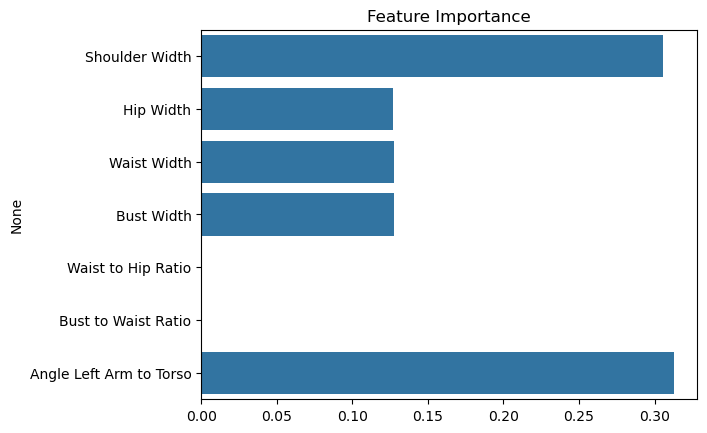

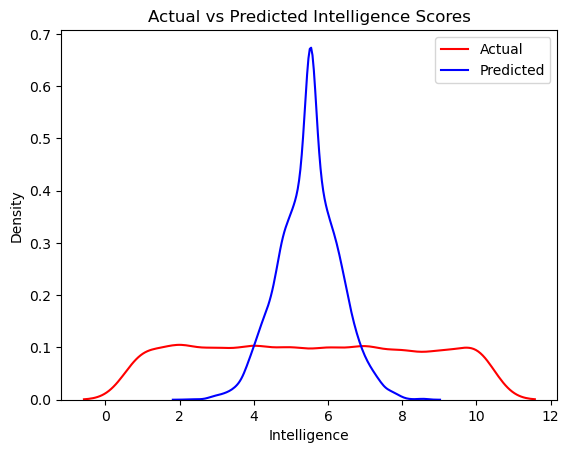

In [ ]:
# Feature Importance
feature_importance = model.feature_importances_
sns.barplot(x=feature_importance, y=X.columns)
plt.title('Feature Importance')
plt.show()

# Plot Actual vs. Predicted
fig, ax = plt.subplots()
sns.kdeplot(y_test['Intelligence'], ax=ax, color='r', label='Actual')
sns.kdeplot(y_pred[:, 0], ax=ax, color='b', label='Predicted')
ax.set_title('Actual vs Predicted Intelligence Scores')
ax.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error

# Make predictions and evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
explained_variance = explained_variance_score(y_test, y_pred)
print(f"Explained Variance Score: {explained_variance}")

Mean Absolute Error: 2.560798809925138
Root Mean Squared Error: 2.99357796969856
Mean Squared Error: 8.961509060664552
Explained Variance Score: -0.09086359998652489


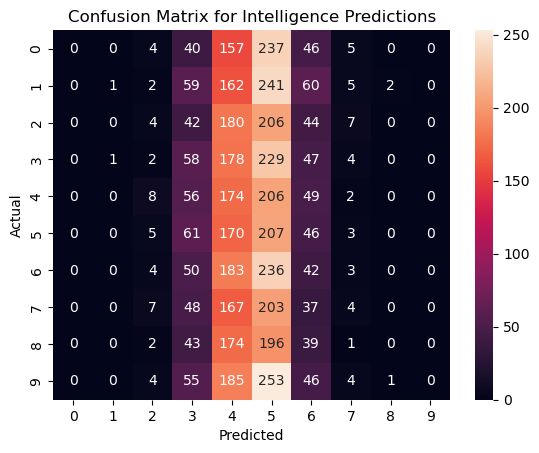

In [ ]:
cm = confusion_matrix(y_test['Intelligence'], y_pred[:, 0].round())  # Adjust indexing for multiclass/multilabel
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Intelligence Predictions')
plt.show()

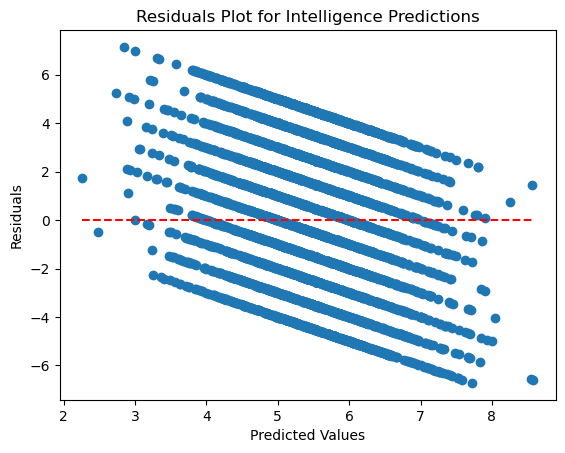

In [ ]:
residuals = y_test['Intelligence'] - y_pred[:, 0]  # Assuming the first column of y_pred corresponds to 'Intelligence'

plt.scatter(y_pred[:, 0], residuals)
plt.hlines(y=0, xmin=y_pred[:, 0].min(), xmax=y_pred[:, 0].max(), colors='red', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot for Intelligence Predictions')
plt.show()


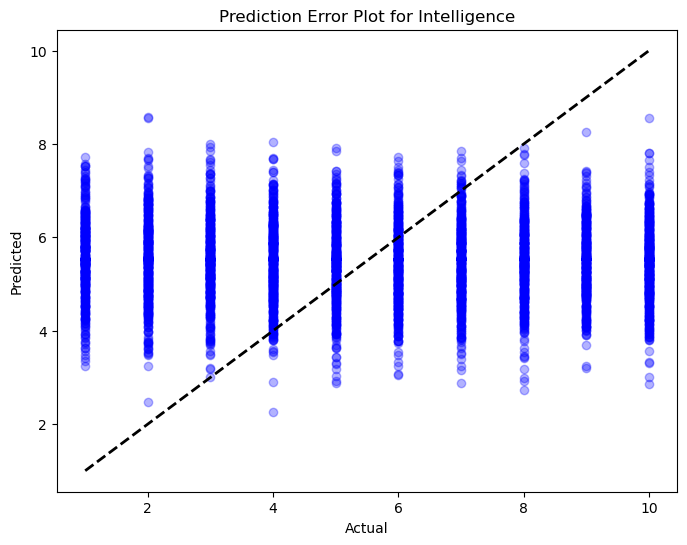

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test['Intelligence'], y_pred[:, 0], alpha=0.3, color='blue')  # Adjust as necessary for your target
plt.plot([y_test['Intelligence'].min(), y_test['Intelligence'].max()], [y_test['Intelligence'].min(), y_test['Intelligence'].max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Prediction Error Plot for Intelligence')
plt.show()
